<a href="https://colab.research.google.com/github/Tarleton-Math/data-science-20-21/blob/master/data_science_20_21_notes_10_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Decision Trees & Random Forests
## Class Notes 2020-10-20
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook

In [1]:
! pip install --upgrade numpy
! pip install --upgrade pandas

     |█████████████████████████████   | 13.1MB 2.7MB/s eta 0:00:01ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)


Today we meet some new supervised algorithms, collectively called "Tree-Based" methods.

But first, recall the day 1 notes where we talked about "weak vs strong" learners and the [Wisdom of the Crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd).  The upshot that, is many cases, the combined prediction from many not-so-great sources is better than one great source.

One Decision Tree is a single not-so-great predictor.  We combined a bunch of them to form a much better "ensemble" predictor called a Random Forest.

## Decision Trees

https://scikit-learn.org/stable/modules/tree.html

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
plt.style.use('fivethirtyeight')

rng = np.random.RandomState(42)

data = load_iris()
# print(data.DESCR)
n, d = data.data.shape
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.Series(data.target)

holdout_frac = 0.10
holdout_splitter = StratifiedShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=rng)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X.iloc[model_idx]  , y.iloc[model_idx]
X_h, y_h = X.iloc[holdout_idx], y.iloc[holdout_idx]
X_m.shape, X_h.shape

def display_results(grid, cutoff=1.0):
    res = grid.cv_results_
    df = pd.DataFrame(res['params'])
    df['score'] = (res['mean_test_score'] * 100)
    mask = df['score'] >= df['score'].max() * min(1-cutoff, 1)
    with pd.option_context('display.max_rows', 100, 'precision', 2):
        display(df[mask].sort_values('score', ascending=False))
    return df

def display_confusion_matrix(y_true, y_pred):
    """Pretty display for confusion matrix"""
    labels = y_true.unique()
    cf = confusion_matrix(y_true, y_pred, labels)
    acc = cf.trace() / cf.sum() * 100
    df = pd.DataFrame(cf, columns=labels, index=labels)
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title(f'accuracy={acc:.2f}%')
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    plt.show()
    return df

In [14]:
import pydotplus
import graphviz
from IPython.display import Image  
def viz_tree(tree, feat_names, targ_names):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                    feature_names=feat_names,  
                                    class_names=targ_names,  
                                    filled=True, rounded=True,  
                                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png(), width=800))

For a moment, let's skip cross-validation.  It'll be easier to focus on learning about decision trees without the complexity cv brings.  But, we always need to do cv when building a real model.

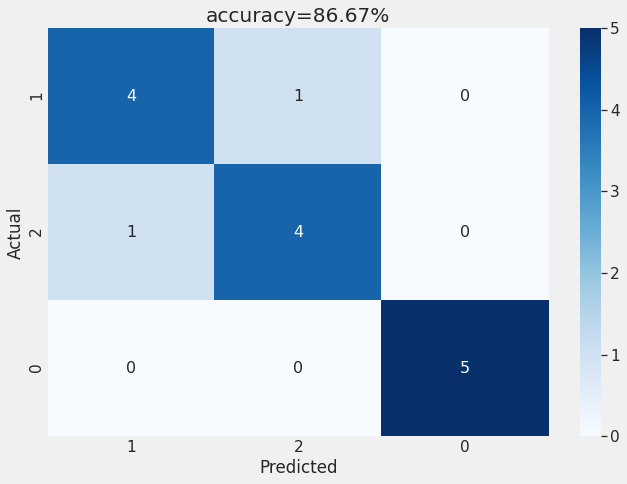

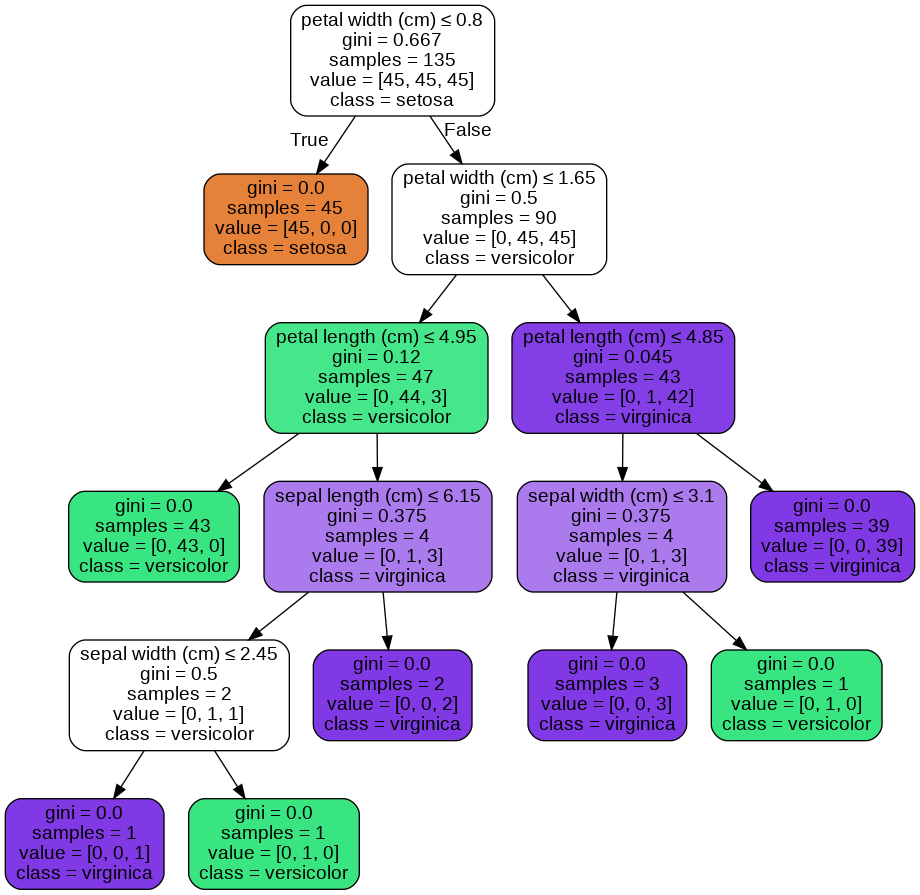

In [15]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_m, y_m)
display_confusion_matrix(y_h, clf.predict(X_h));
viz_tree(tree, X_m.columns, data.target_names)

Let's try apply PCA to reduce to 2 dimensions.

We're NOT doing this because we believe it'll improve the model.  We're doing it because we want to plot the decision boundarya and 2D plots are easier to understand to 4D plots:)

Recall that PCA "mixes up" the columns (linear combinations) so that the first new column "explains" as much variance as possible.  Explained variance decreases with each new principle components.

But, the new columns don't have "names" like the original columns.  In other words, the new columns are abstract combinations of the originals that do NOT correspond to physical measurements.  So, they get generic names PC0, PC1, ...

,PC0,PC1
0,-2.623750,-0.181971
1,1.954771,0.191009
2,-2.878486,-0.564702
3,1.912192,0.139197
4,-2.498857,-0.140791
5,-2.664966,-0.105618
6,2.132619,-0.201491
7,-2.706004,-0.242376
8,0.384387,-0.281578
9,-2.737174,-0.304025


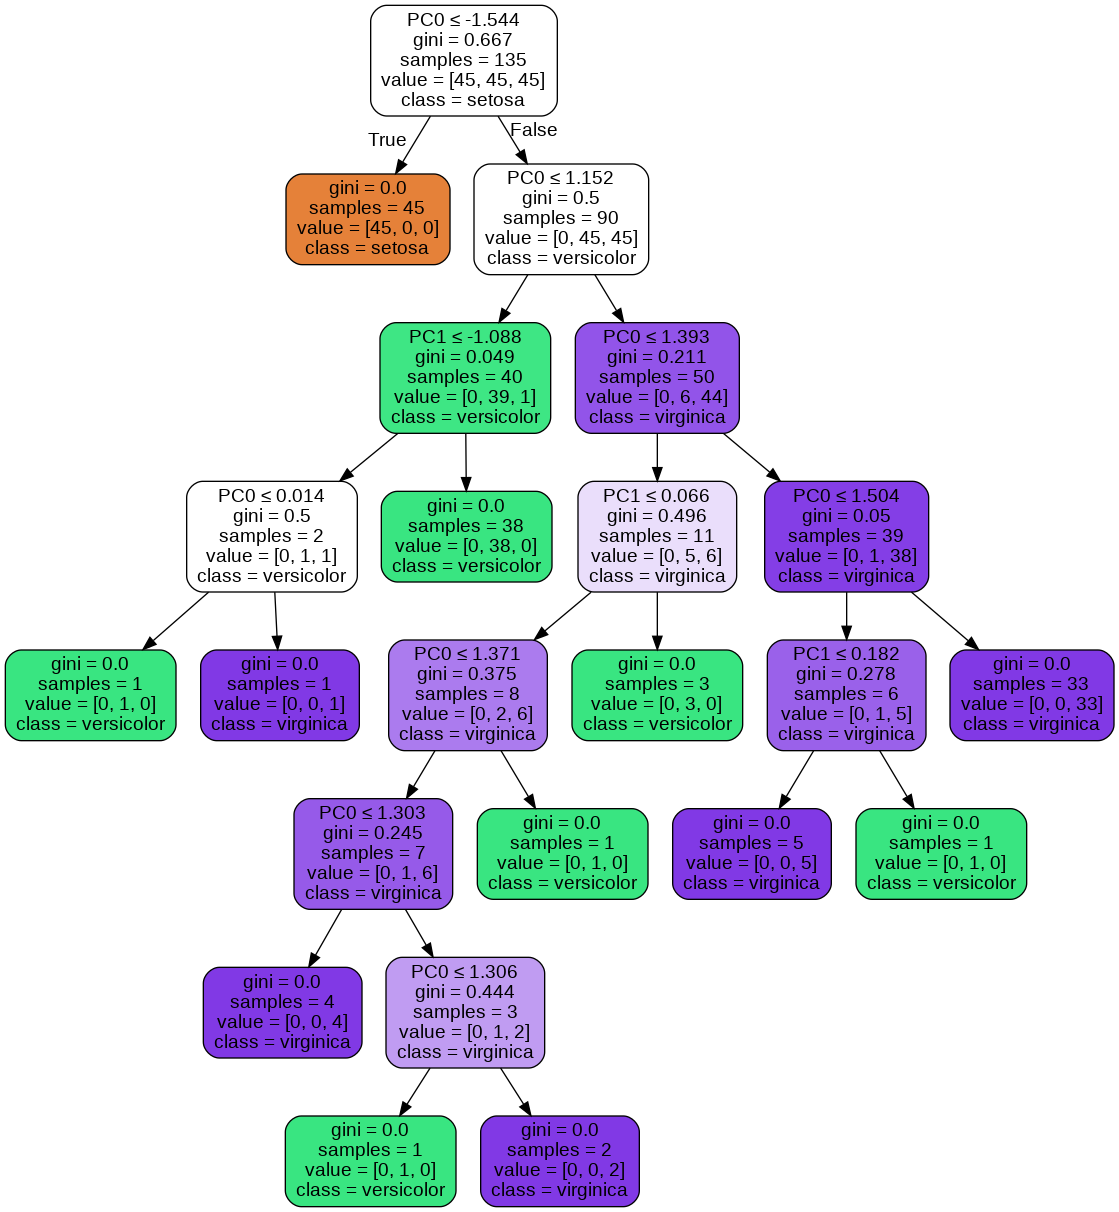

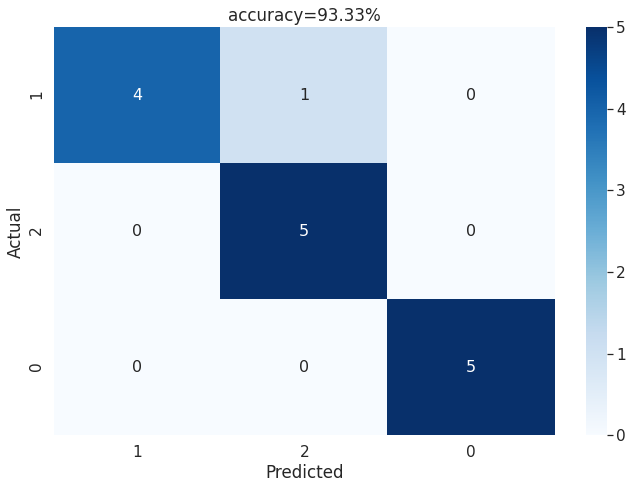

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_m)
cols = [f"PC{i}" for i in range(pca.n_components)]
X_m_pca = pd.DataFrame(pca.transform(X_m), columns=cols)
X_h_pca = pd.DataFrame(pca.transform(X_h), columns=cols)

display(X_m_pca.head(10))

clf = clf.fit(X_m_pca, y_m)
viz_tree(tree, X_m_pca.columns, data.target_names)
display_confusion_matrix(y_h, clf.predict(X_h_pca));

Now that we're in 2 dimensions, we can visualize the *decision boundary*.

- def: The decision boundary is the surface dividing regions that would get different class predictions from the classifier.

We'll modify code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

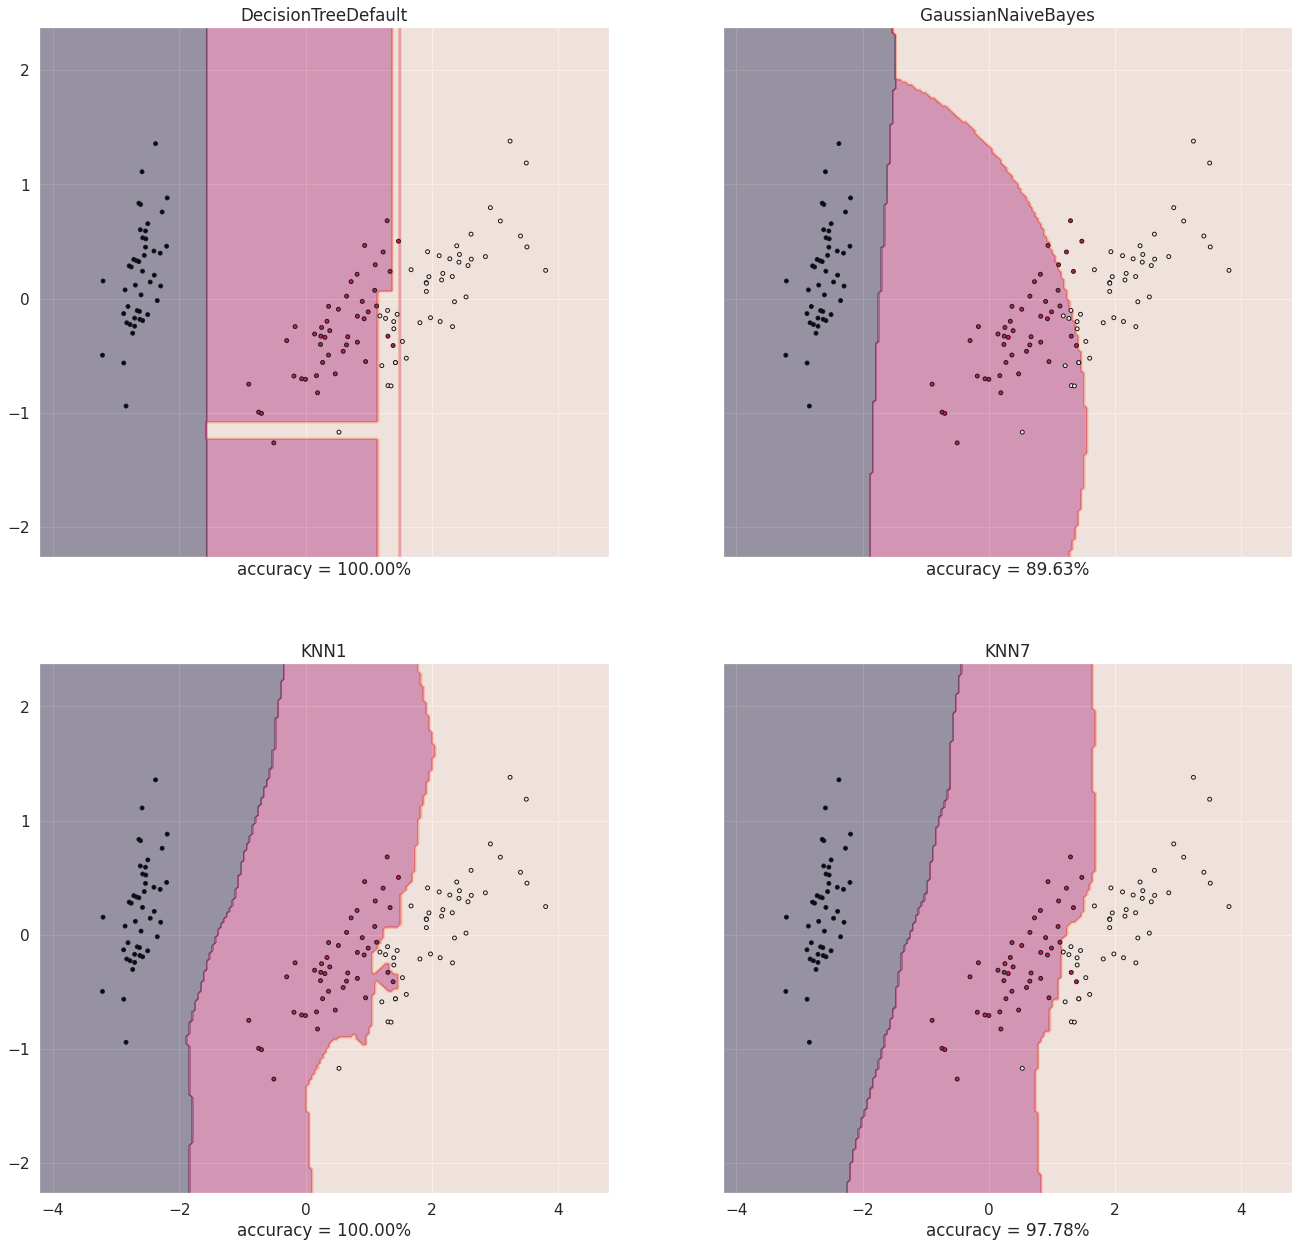

In [32]:
from itertools import product
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def interp(x, mesh):
    return np.linspace(x.min()-1, x.max()+1, mesh)

def plot_decision_boundary(X, y, clfs, mesh=100):
    # Determine shape of plot grid
    N = len(clfs)  # number of plots
    cols = int(min(2, N))  # up to 2 cols
    rows = int(np.ceil(N / cols))  # compute number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols*10,rows*10), sharex=True, sharey=True, squeeze=False)  # Create plot grid

    # Create a mesh of "fake" points for clf to predict on and create the colored regions
    X = np.asarray(X)
    XX = np.apply_along_axis(interp, axis=0, arr=X, mesh=mesh)  # interpolates each dimension
    XX = np.meshgrid(*XX.T)  # does a cartesian product (sort of) to create (x,y) points from the interpolated values above
    ZZ = np.array([xx.ravel() for xx in XX]).T  # Flatten XX to the shape needed to input into clf

    i = j = 0  # track which plot we're plotting into
    for name, clf in clfs.items():
        ax = axes[i,j]
        clf.fit(X, y)
        acc = accuracy_score(y, y_pred = clf.predict(X))
        yy = clf.predict(ZZ).reshape(XX[0].shape)
        ax.contourf(*XX, yy, alpha=0.4)
        ax.scatter(*X.T, c=y, s=15, edgecolor='k', linewidth=1)
        ax.set_title(name)
        ax.set_xlabel(f"accuracy = {acc*100:.2f}%")

        j += 1
        if j >= cols:
            i += 1
            j = 0

clfs = {
        'DecisionTreeDefault': DecisionTreeClassifier(random_state=1),
        'GaussianNaiveBayes': GaussianNB(),
        'KNN1': KNeighborsClassifier(n_neighbors=1),
        'KNN7': KNeighborsClassifier(n_neighbors=7),
        }

plot_decision_boundary(X_m_pca, y_m, clfs, mesh=200)

Wait ... DT is claiming 100% accuracy, but some of those red dots look like they are in the white region.  On the other hand, we expect 100% accuracy because the DT is not contrained and the dots are the same data it is trained on.  So the treee *should* get 100% accuracy by wildly overfitting.

Let's use a finer mesh and only plot that image so we can make it bigger.

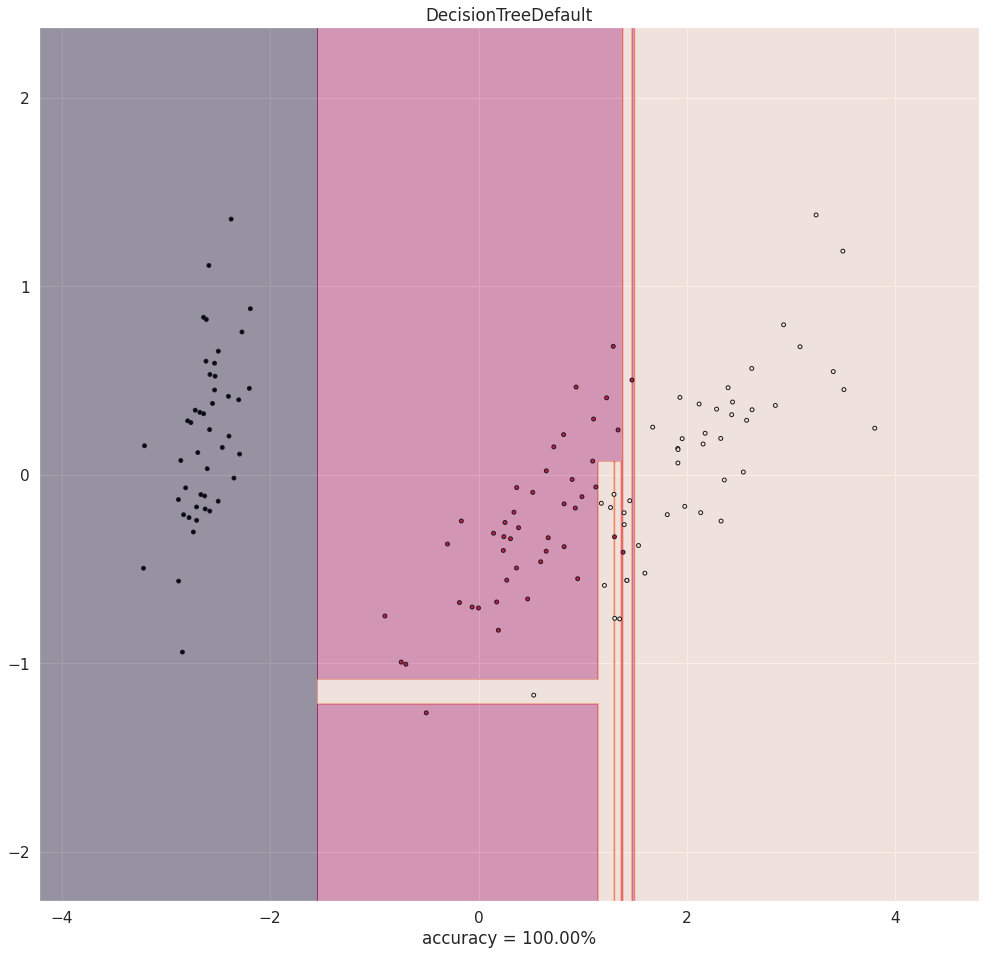

In [24]:
clfs = {
        'DecisionTreeDefault': DecisionTreeClassifier(random_state=1),
        }

plot_decision_boundary(X_m_pca, y_m, clfs, mesh=1000)


Wow, talk about overfitting!!  This is why we need to control hyperparameters like max_depth.  Let's dig into those hyperparameters.

- Decision Trees hyperparameters - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    - Note "random state" - The algorithm
- Splitting Criterion - Gini vs Entropy - https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb


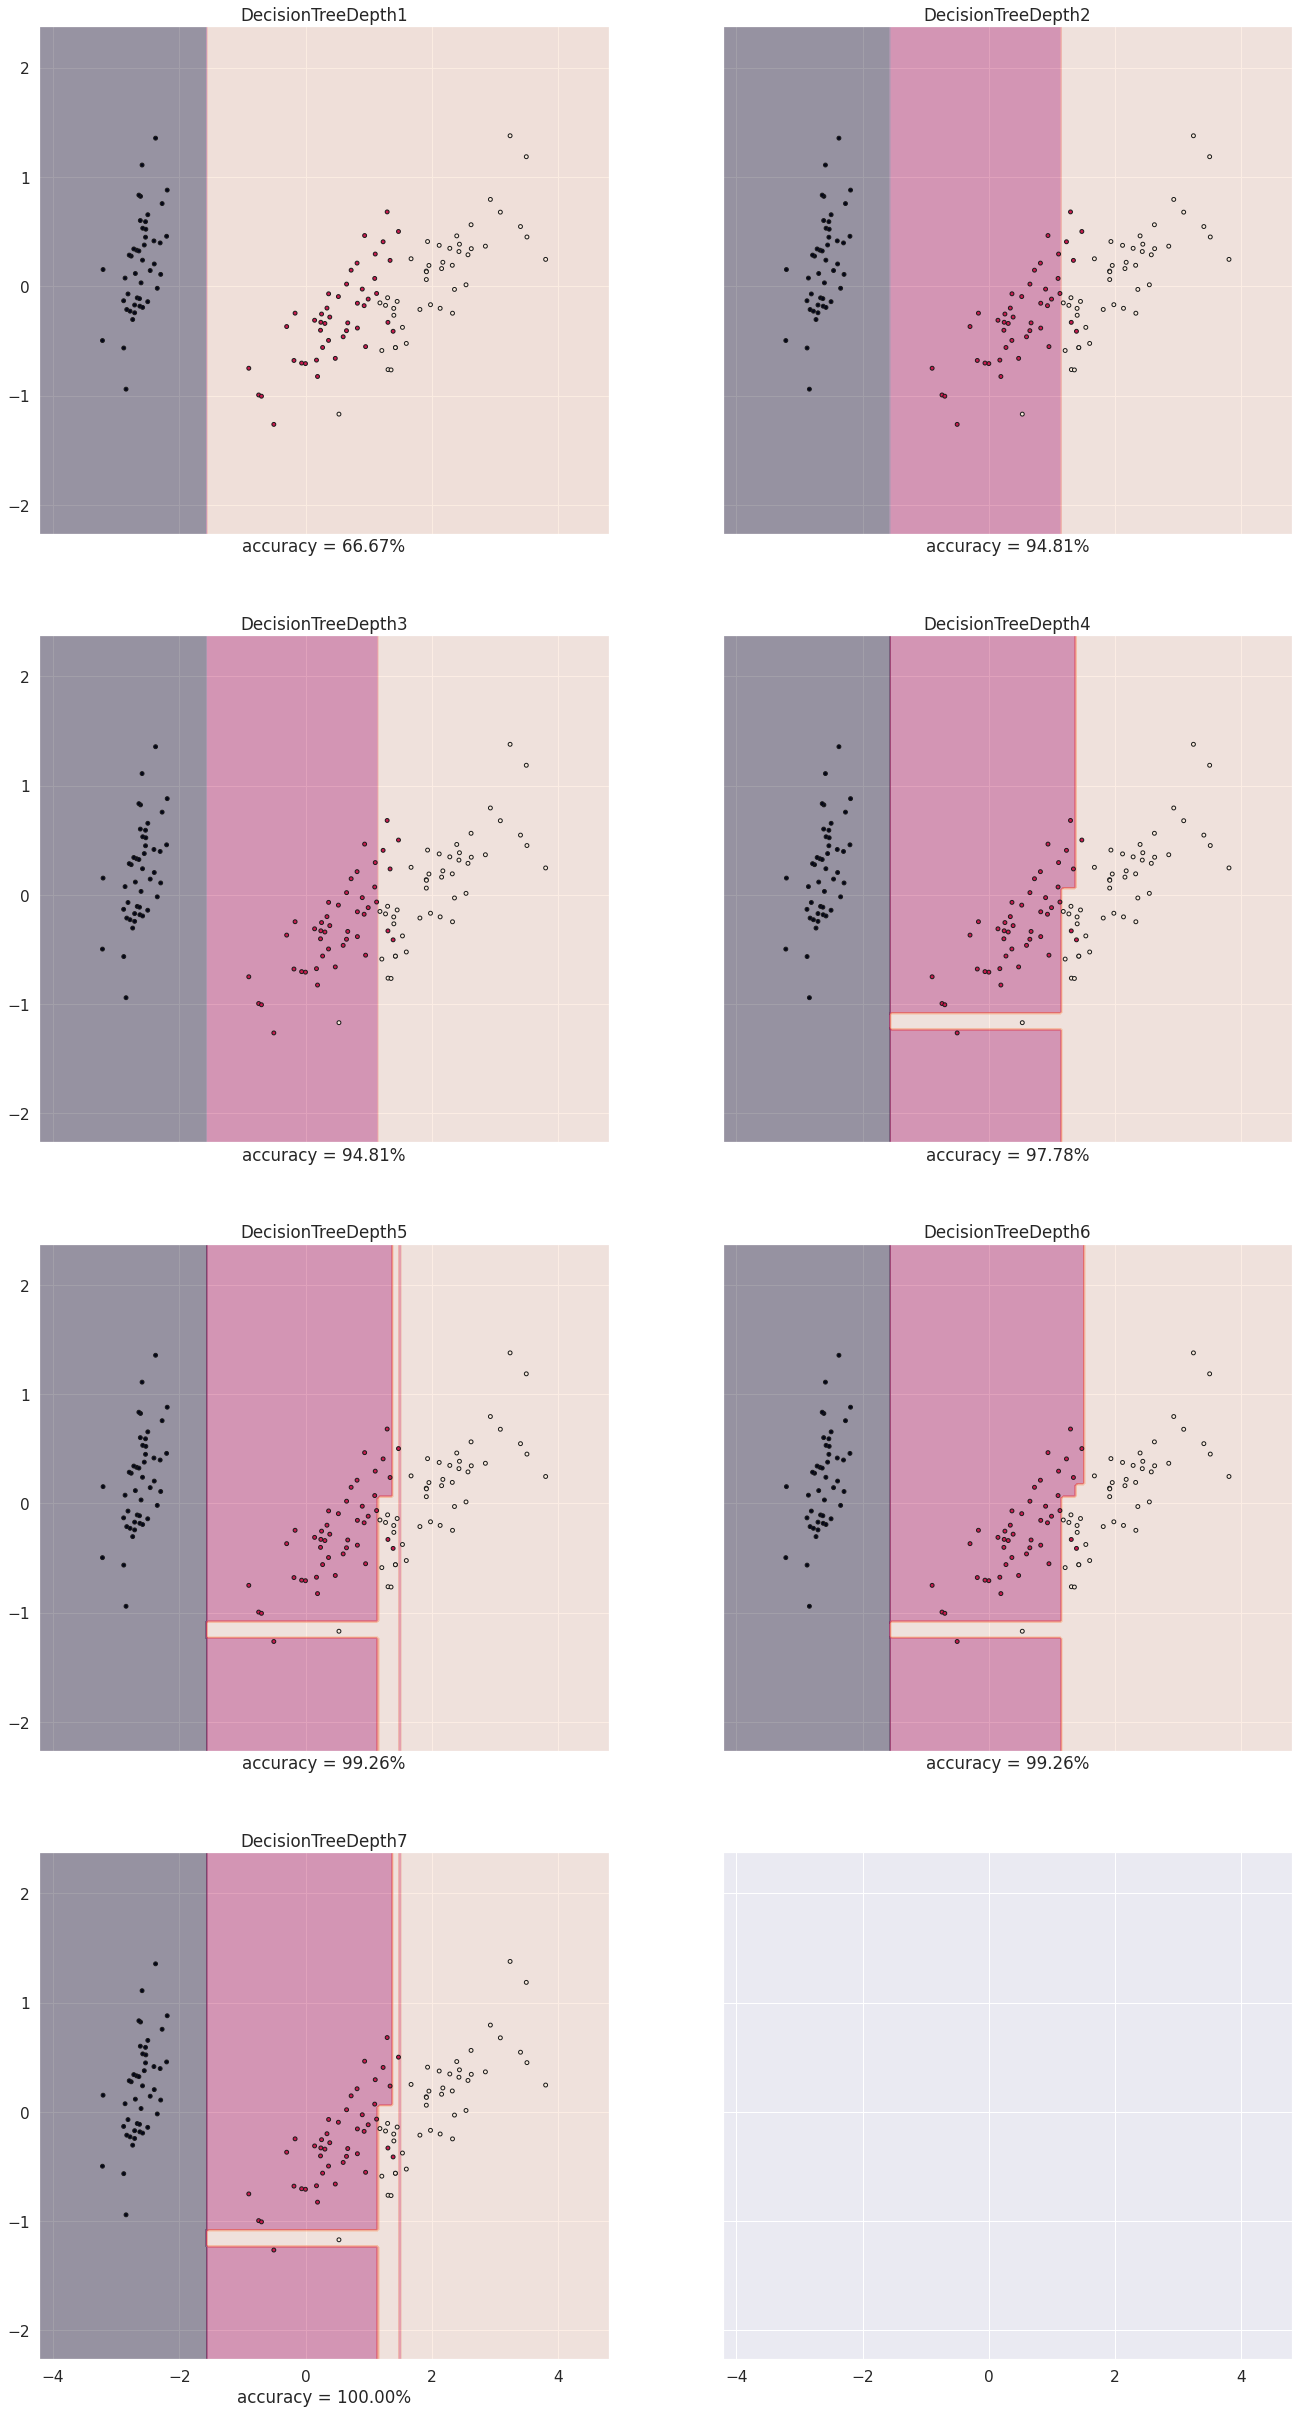

In [33]:
clfs = {
        'DecisionTreeDepth1': DecisionTreeClassifier(random_state=1, max_depth=1),
        'DecisionTreeDepth2': DecisionTreeClassifier(random_state=1, max_depth=2),
        'DecisionTreeDepth3': DecisionTreeClassifier(random_state=1, max_depth=3),
        'DecisionTreeDepth4': DecisionTreeClassifier(random_state=1, max_depth=4),
        'DecisionTreeDepth5': DecisionTreeClassifier(random_state=1, max_depth=5),
        'DecisionTreeDepth6': DecisionTreeClassifier(random_state=1, max_depth=6),
        'DecisionTreeDepth7': DecisionTreeClassifier(random_state=1, max_depth=7),
        # 'DecisionTreeDepth2MinSplit4': DecisionTreeClassifier(random_state=1, max_depth=2, min_samples_split=4),
        }

plot_decision_boundary(X_m_pca, y_m, clfs, mesh=200)

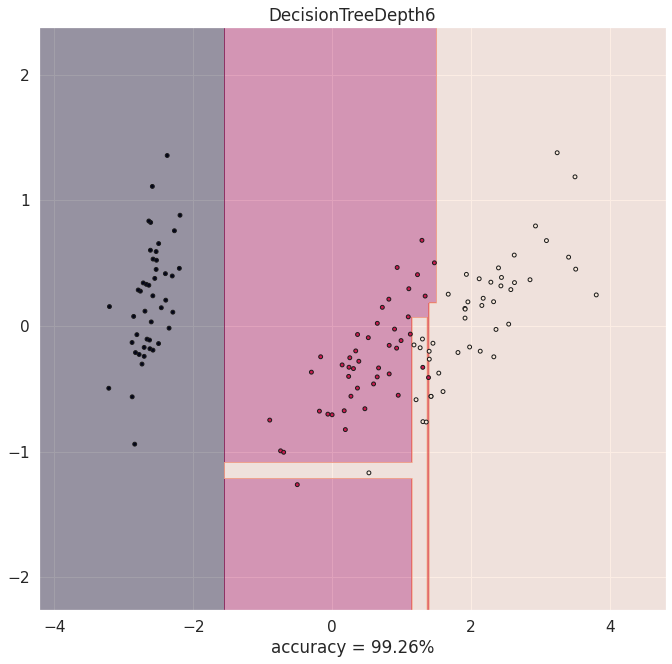

In [37]:
clfs = {
        # 'DecisionTreeDepth1': DecisionTreeClassifier(random_state=1, max_depth=1),
        # 'DecisionTreeDepth2': DecisionTreeClassifier(random_state=1, max_depth=2),
        # 'DecisionTreeDepth3': DecisionTreeClassifier(random_state=1, max_depth=3),
        # 'DecisionTreeDepth4': DecisionTreeClassifier(random_state=1, max_depth=4),
        # 'DecisionTreeDepth5': DecisionTreeClassifier(random_state=1, max_depth=5),
        'DecisionTreeDepth6': DecisionTreeClassifier(random_state=1, max_depth=6),
        # 'DecisionTreeDepth7': DecisionTreeClassifier(random_state=1, max_depth=7),
        # 'DecisionTreeDepth2MinSplit4': DecisionTreeClassifier(random_state=1, max_depth=2, min_samples_split=4),
        }

plot_decision_boundary(X_m_pca, y_m, clfs, mesh=1000)

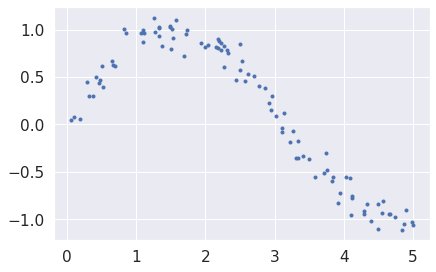

In [67]:
from sklearn import tree
X = rng.uniform(0, 5, (100,1))
y = np.sin(X) + rng.normal(0, 0.1, X.shape)

reg = tree.DecisionTreeRegressor()
reg = reg.fit(X, y)
y_pred = reg.predict(X)
plt.plot(X,y, '.')


In class task - write plot_regressor to visualize resgressors similar to plot_decision_boundary

# Apply to Boston Housing dataset - Later

In [9]:
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.datasets import load_boston

data = load_boston()
print(data.DESCR)
n, d = data.data.shape
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.Series(data.target)

holdout_frac = 0.10
holdout_splitter = ShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=rng)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X.iloc[model_idx]  , y.iloc[model_idx]
X_h, y_h = X.iloc[holdout_idx], y.iloc[holdout_idx]
X_m.shape, X_h.shape

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

((455, 13), (51, 13))

In [10]:
X_m.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
103,0.21161,0.0,8.56,0.0,0.520,6.137,87.4,2.7147,5.0,384.0,20.9,394.47,13.44
195,0.01381,80.0,0.46,0.0,0.422,7.875,32.0,5.6484,4.0,255.0,14.4,394.23,2.97
56,0.02055,85.0,0.74,0.0,0.410,6.383,35.7,9.1876,2.0,313.0,17.3,396.90,5.77
491,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07
115,0.17134,0.0,10.01,0.0,0.547,5.928,88.2,2.4631,6.0,432.0,17.8,344.91,15.76


In [11]:
X_m['RAD'].value_counts()

24.0    124
5.0     103
4.0      99
3.0      33
8.0      23
6.0      22
1.0      19
2.0      18
7.0      14
Name: RAD, dtype: int64

In [12]:
from sklearn import tree
reg = tree.DecisionTreeRegressor()
reg = reg.fit(X_m, y_m)
# display_confusion_matrix(y_h, clf.predict(X_h));
# viz_tree(tree, X_m.columns, data.target_names)